# Reproducibility challenge
### Fundamentals of Inference and Learning, EE-411
#### Thomas Lenges, Renuka Singh Virk

In this notebook, we attempt to reproduce the double descent curves from the paper "Reconciling modern machine learning practice and the bias-variance trade-of" by $\textit{Mikhail Belkin}$, $\textit{Daniel Hsu}$, $\textit{Siyuan Ma}$, $\textit{Soumik Mandal}$.

### Audio
The code below is to get a sound when a cell finishes running :)

In [ ]:
from google.colab import files

# Upload your audio file (choose a .mp3 or .wav file)
uploaded = files.upload()


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
from IPython.display import Audio, display

# Play the uploaded audio file
sound = Audio("result.wav", autoplay=True)  # Replace 'beep.wav' with your uploaded filename

## Double descent risk curve for RFF model on MNIST.

In the following section, we reproduce the results of Figure 2 of the paper.

Section B, 'Experimental setup' of the paper provides insights on how the plots were generated.
As indicated in Figure 2, the authors of the paper used a subset of the MNIST dataset ($n=10^4$, $10$ classes).

The steps to apply are the following:
- Transform images to grayscale images (not necessary for MNIST as it is already grayscale)
- Scale the maximum range of each feature to $[0,1]$
- Perform one-hot encoding
- Subsample a training set (size $n$) uniformly at random without replacement

Note that the number of random fourier features in Figure 2 ranges from $0$ to $60000$, however our system crashes for $n=40000$ or $n=60000$, which is why we limit to $20000$. However this should be sufficient to conclude whetheru the figure was reproduced properly or not.

Import libraries, datasets and define useful functions:

In [1]:
# Imports
import numpy as np
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
# Hyperparameters
num_training_data = 10000 # Subsample size
num_test_data = 10000     # Use the full MNIST test set
num_classes = 10          # Number of classes
sigma = 5.0               # Bandwidth for Gaussian kernel (See appendix C.1)
# num_rff = [50, 200, 500, 1000, 1500, 2000, 3000, 4000, 5000, 7000, 8000, 9000, 10000, 11000, 13000, 15000, 20000] # RFF dimensions
num_rff = [50, 200, 500, 1000, 3000, 5000, 8000, 10000, 12000, 20000] # RFF dimensions
seed = 42                 # Random seed for reproducibility

# Set random seed
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
# Data Preprocessing: Load MNIST
def preprocess_mnist():
    transform = transforms.Compose([
        transforms.ToTensor(),                      # Scale to [0, 1]
        transforms.Lambda(lambda x: x.view(-1))     # Flatten image (28x28)
    ])

    # Load MNIST dataset
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Subsample training data
    indices = np.random.choice(len(mnist_train), num_training_data, replace=False)
    train_subset = torch.utils.data.Subset(mnist_train, indices)
    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=num_training_data, shuffle=False) # XXX

    test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=num_test_data, shuffle=False)

    # Extract training and test data
    x_train, y_train = next(iter(train_loader))
    x_test, y_test = next(iter(test_loader))

    # One-hot encode labels
    y_train_onehot = torch.nn.functional.one_hot(y_train, num_classes=num_classes).float()
    y_test_onehot = torch.nn.functional.one_hot(y_test, num_classes=num_classes).float() # For compatibility with neural networks


    return x_train, y_train_onehot, x_test, y_test_onehot

x_train, y_train, x_test, y_test = preprocess_mnist()

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 488kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.85MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.77MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# Generate Random Fourier Features (RFF)
def generate_rff(x, D, d, sigma):
    weights = torch.randn(D, d // 2) * (1 / sigma) # Randomly sample weights from a normal distribution (scaled by 1/sigma)
    projection = x @ weights
    rff_features = torch.cat([torch.sin(projection), torch.cos(projection)], dim=-1)
    return rff_features

# Train using RFF
def train_rff(x_train, y_train, x_test, y_test, d, sigma):
    # Generate RFF features
    rff_train = generate_rff(x_train, x_train.shape[1], d, sigma)
    rff_test = generate_rff(x_test, x_train.shape[1], d, sigma)

    # Solve linear system to find weights
    A = rff_train.T @ rff_train
    b = rff_train.T @ y_train
    alpha = torch.linalg.solve(A, b)

    # Calculate L2 norm of weights
    l2_norm = torch.norm(alpha).item()

    # Predictions
    y_train_pred = rff_train @ alpha
    y_test_pred = rff_test @ alpha

    # Compute Zero-One Loss
    train_zero_one_loss = (torch.argmax(y_train_pred, dim=1) != torch.argmax(y_train, dim=1)).float().mean().item()
    test_zero_one_loss = (torch.argmax(y_test_pred, dim=1) != torch.argmax(y_test, dim=1)).float().mean().item()

    # Compute Squared Loss
    train_squared_loss = torch.mean((y_train_pred - y_train) ** 2).item()
    test_squared_loss = torch.mean((y_test_pred - y_test) ** 2).item()

    return train_zero_one_loss, test_zero_one_loss, train_squared_loss, test_squared_loss, l2_norm


In [5]:
# Exact Gaussian Kernel
def gaussian_kernel(x1, x2, sigma):
    # Compute the squared distance between points
    sq_dists = torch.cdist(x1, x2) ** 2
    # Apply the kernel formula
    return torch.exp(-sq_dists / (2 * sigma ** 2))

# Compute h_{n, ∞} (for test metrics only)
def compute_h_n_infinity_test_metrics(x_train, y_train, x_test, y_test, sigma):
    # Build kernel matrices
    K_train = gaussian_kernel(x_train, x_train, sigma)  # Kernel matrix for training data
    K_test = gaussian_kernel(x_test, x_train, sigma)    # Kernel matrix for test vs. training data

    # Solve for alpha: (K^T K)^{-1} K^T y
    A = K_train.T @ K_train
    b = K_train.T @ y_train
    alpha = torch.linalg.solve(A, b)  # Solve for weights

    # Make predictions for test data
    y_test_pred = K_test @ alpha

    # Compute test zero-one loss
    test_zero_one_loss = (torch.argmax(y_test_pred, dim=1) != torch.argmax(y_test, dim=1)).float().mean().item()

    # Compute test squared loss
    test_squared_loss = torch.mean((y_test_pred - y_test) ** 2).item()

    # Compute L2 norm of alpha (weights)
    l2_norm = torch.norm(alpha).item()

    return test_zero_one_loss, test_squared_loss, l2_norm


In [6]:
# Generate results
train_zero_one_losses = []
test_zero_one_losses = []
train_squared_losses = []
test_squared_losses = []
l2_norms = []

# Compute h_{n, ∞} test metrics
hn_inf_test_zero_one_loss, hn_inf_test_squared_loss, hn_inf_l2_norm = compute_h_n_infinity_test_metrics(x_train, y_train, x_test, y_test, sigma)


for d in num_rff:
    print(f"Training with {d} random Fourier features...")
    train_zero_one_loss, test_zero_one_loss, train_squared_loss, test_squared_loss, l2_norm = train_rff(x_train, y_train, x_test, y_test, d, sigma)
    train_zero_one_losses.append(train_zero_one_loss)
    test_zero_one_losses.append(test_zero_one_loss)
    train_squared_losses.append(train_squared_loss)
    test_squared_losses.append(test_squared_loss)
    l2_norms.append(l2_norm)

Training with 50 random Fourier features...
Training with 200 random Fourier features...
Training with 500 random Fourier features...
Training with 1000 random Fourier features...
Training with 3000 random Fourier features...
Training with 5000 random Fourier features...
Training with 8000 random Fourier features...
Training with 10000 random Fourier features...
Training with 12000 random Fourier features...
Training with 20000 random Fourier features...


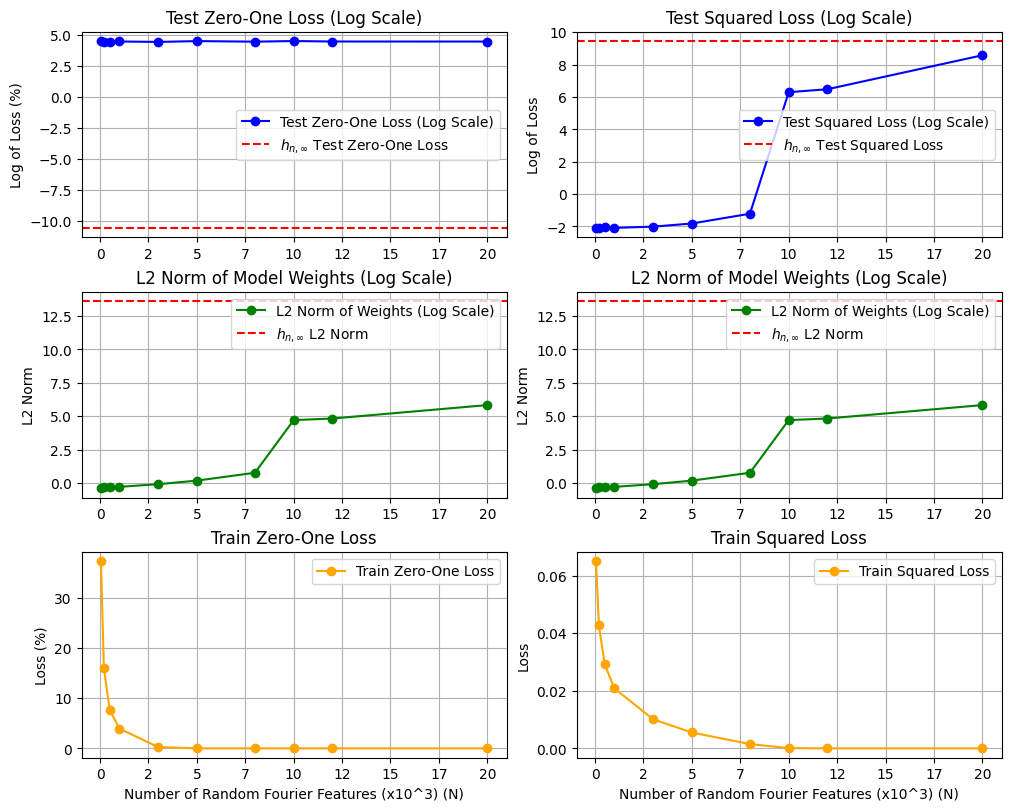

In [15]:
fig, axs = plt.subplots(3, 2, figsize=(10, 8), constrained_layout=True)
num_rff = np.array(num_rff)

# Column 1: Zero-One Loss
# Test Zero-One Loss (Log Scale)
axs[0, 0].plot(num_rff / 1000, np.log(np.array(test_zero_one_losses) * 100), label='Test Zero-One Loss (Log Scale)', marker='o', color='blue')
axs[0, 0].axhline(y=np.log(hn_inf_test_zero_one_loss) * 100, color='red', linestyle='--', label='$h_{n, \infty}$ Test Zero-One Loss')
axs[0, 0].set_title('Test Zero-One Loss (Log Scale)')
axs[0, 0].set_ylabel('Log of Loss (%)')
axs[0, 0].grid()
axs[0, 0].legend()

# L2 Norms of Weights
axs[1, 0].plot(num_rff / 1000, np.log(l2_norms), label='L2 Norm of Weights (Log Scale)', marker='o', color='green')
axs[1, 0].axhline(y=np.log(hn_inf_l2_norm), color='red', linestyle='--', label='$h_{n, \infty}$ L2 Norm')
axs[1, 0].set_title('L2 Norm of Model Weights (Log Scale)')
axs[1, 0].set_ylabel('L2 Norm')
axs[1, 0].grid()
axs[1, 0].legend()

# Train Zero-One Loss
axs[2, 0].plot(num_rff / 1000, np.array(train_zero_one_losses) * 100, label='Train Zero-One Loss', marker='o', color='orange')
axs[2, 0].set_title('Train Zero-One Loss')
axs[2, 0].set_xlabel('Number of Random Fourier Features (x10^3) (N)')
axs[2, 0].set_ylabel('Loss (%)')
axs[2, 0].grid()
axs[2, 0].legend()

# Column 2: Squared Loss
# Test Squared Loss (Log Scale)
axs[0, 1].plot(num_rff / 1000, np.log(test_squared_losses), label='Test Squared Loss (Log Scale)', marker='o', color='blue')
axs[0, 1].axhline(y=np.log(hn_inf_test_squared_loss), color='red', linestyle='--', label='$h_{n, \infty}$ Test Squared Loss')
axs[0, 1].set_title('Test Squared Loss (Log Scale)')
axs[0, 1].set_ylabel('Log of Loss')
axs[0, 1].grid()
axs[0, 1].legend()

# L2 Norms of Weights
axs[1, 1].plot(num_rff / 1000, np.log(l2_norms), label='L2 Norm of Weights (Log Scale)', marker='o', color='green')
axs[1, 1].axhline(y=np.log(hn_inf_l2_norm), color='red', linestyle='--', label='$h_{n, \infty}$ L2 Norm')
axs[1, 1].set_title('L2 Norm of Model Weights (Log Scale)')
axs[1, 1].set_ylabel('L2 Norm')
axs[1, 1].grid()
axs[1, 1].legend()

# Train Squared Loss
axs[2, 1].plot(num_rff / 1000, train_squared_losses, label='Train Squared Loss', marker='o', color='orange')
axs[2, 1].set_title('Train Squared Loss')
axs[2, 1].set_xlabel('Number of Random Fourier Features (x10^3) (N)')
axs[2, 1].set_ylabel('Loss')
axs[2, 1].grid()
axs[2, 1].legend()

# Format x-axis to show integers
for ax in axs.flatten():
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))  # Force integer ticks



In [ ]:
display(sound)

## Double descent risk curve for fully connected neural network model on MNIST.

In [22]:
# Imports
import torch.nn as nn
import torch.optim as optim

In [23]:
# Dataset preparation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [24]:
# Model definition
class FullyConnectedNN(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_units)
        self.fc2 = nn.Linear(hidden_units, output_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [25]:
# Training and evaluation
# "Weight reuse" scheme not yet used (always equal to "None") (see paper search for "Weight reuse")
# Always same step size epochs for the moment (no decay the step size after 500 epochs yet implemented)
def train_and_evaluate(hidden_units, train_loader, test_loader, reuse_weights=None):
    model = FullyConnectedNN(784, hidden_units, 10)
    if reuse_weights is not None:
        model.fc1.weight.data[:reuse_weights.size(0)] = reuse_weights

    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95)
    criterion = nn.MSELoss()

    # Training loop
    for epoch in range(6000):
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, torch.nn.functional.one_hot(target, num_classes=10).float())
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_zero_one_loss = (torch.argmax(output, dim=1) != target).float().mean().item()
            test_squared_loss = torch.mean((output - torch.nn.functional.one_hot(target, num_classes=10).float()) ** 2).item()

    return test_zero_one_loss, test_squared_loss

In [27]:
# Experiment: Vary H and collect results
hidden_units_list = [10, 50, 100, 500, 1000, 5000, 10000]
results = []
for hidden_units in hidden_units_list:
    loss_zero_one, loss_squared = train_and_evaluate(hidden_units, train_loader, test_loader)
    results.append((hidden_units, loss_zero_one, loss_squared))

KeyboardInterrupt: 

In [ ]:
# Plot results
# No results were yet visualized so needs to be adapted to match Figure 4 of paper
import matplotlib.pyplot as plt
hidden_units, zero_one_loss, squared_loss = zip(*results)
plt.plot(hidden_units, zero_one_loss, label="Zero-One Loss")
plt.plot(hidden_units, squared_loss, label="Squared Loss")
plt.xscale("log")
plt.xlabel("Number of Parameters (Hidden Units)")
plt.ylabel("Loss")
plt.legend()
plt.title("Double Descent Risk Curve")
plt.show()
